# GP_Predict Algorithm for Repeated Auctions

## Imports

In [56]:
import numpy as np
import numpy as np
import cvxpy as cp
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from tqdm import tqdm
import pickle
import re
import random

## Bidders

In [57]:
# function to normalize payoffs in [0,1]

def normalize_util(payoffs, min_payoff, max_payoff):
    if min_payoff == max_payoff:
        return payoffs
    payoff_range = max_payoff - min_payoff
    payoffs = np.maximum(payoffs, min_payoff)
    payoffs = np.minimum(payoffs, max_payoff)
    payoffs_scaled = (payoffs - min_payoff) / payoff_range
    return payoffs_scaled


normalize = np.vectorize(normalize_util)

In [58]:
# parent class of bidders

class Bidder:
    def __init__(self, c_limit, d_limit, K, has_seed=False):
        self.K = K
        c_list = c_limit * np.random.sample(size=K)
        d_list = d_limit * np.random.sample(size=K)
        self.action_set = list(zip(c_list, d_list))
        
        # cost is a proper multiple of average bid function which is less than all of bid functions
        ratio_c = (c_list.min() / (2 * np.mean(c_list)))
        ratio_d = (d_list.min() / (2 * np.mean(d_list)))
        cost_ratio = min(ratio_c, ratio_d)
        self.cost = (np.mean(c_list) * cost_ratio, np.mean(d_list) * cost_ratio)
        self.weights = np.ones(K)
        self.history_payoff_profile = []
        self.history_action = []
        self.history_payoff = []
        self.cum_each_action = [0] * K
        self.played_action_day = [] # day
        # to be able to reproduce exact same behavior
        self.has_seed = has_seed
        if self.has_seed:
            self.seed = np.random.randint(1, 10000)
            self.random_state = np.random.RandomState(seed=self.seed)

    # To clear stored data
    def restart(self):
        self.weights = np.ones(self.K)
        self.history_payoff_profile = []
        self.history_action = []
        self.history_payoff = []
        self.cum_each_action = [0] * self.K
        self.played_action_day = [] 
        if self.has_seed:
            self.random_state = np.random.RandomState(seed=self.seed)

    # choose action according to weights
    def choose_action(self):
        mixed_strategies = self.weights / np.sum(self.weights)
        if self.has_seed:
            choice = self.random_state.choice(len(self.action_set), p=mixed_strategies)
        else:
            choice = np.random.choice(len(self.action_set), p=mixed_strategies)
        return self.action_set[choice], choice

In [59]:
# Player using Hedge algorithm (Freund and Schapire. 1997)

class Hedge_bidder(Bidder):
    def __init__(self, c_limit, d_limit, K, max_payoff, T, has_seed=False):
        super().__init__(c_limit, d_limit, K, has_seed)
        self.type = 'Hedge'
        self.T = T
        self.learning_rate = np.sqrt(8 * np.log(self.K) / self.T)
        self.max_payoff = max_payoff

    def update_weights(self, payoffs):
        payoffs = normalize(payoffs, 0, self.max_payoff)
        losses = np.ones(self.K) - np.array(payoffs)
        self.weights = np.multiply(self.weights, np.exp(np.multiply(self.learning_rate, -losses)))
        self.weights = self.weights / np.sum(self.weights)

In [60]:
# Player choosing actions uniformly random each time

class random_bidder(Bidder):
    def __init__(self, c_limit, d_limit, K, has_seed=False):
        super().__init__(c_limit, d_limit, K, has_seed)
        self.type = 'random'

In [61]:
# Player using EXP3.P algorithm (Auer et al. 2002) with params according to Theorem 3.2 of 
# [Regret Analysis of Stochastic and Nonstochastic Multi-armed Bandit Problems, S. Bubeck, N. Cesa-Bianchi, 2012]

class EXP3_bidder(Bidder):
    def __init__(self, c_limit, d_limit, K, max_payoff, T, has_seed=False):
        super().__init__(c_limit, d_limit, K, has_seed)
        self.type = 'EXP3'
        self.rewards_est = np.zeros(K)
        self.T = T
        self.max_payoff = max_payoff

        delta = 0.01
        self.beta = np.sqrt(np.log(self.K * (1 / delta)) / (self.T * self.K))
        self.gamma = 1.05 * np.sqrt(np.log(self.K) * self.K / self.T)
        self.learning_rate = 0.95 * np.sqrt(np.log(self.K) / (self.T * self.K))
        assert 0 < self.beta < 1 and 0 < self.gamma < 1

    def update_weights(self, played_a, payoff):
        prob = self.weights[played_a] / np.sum(self.weights)
        payoff = normalize(payoff, 0, self.max_payoff)

        self.rewards_est = self.rewards_est + self.beta * np.divide(np.ones(self.K),
                                                                    self.weights / np.sum(self.weights))
        self.rewards_est[played_a] = self.rewards_est[played_a] + payoff / prob

        self.weights = np.exp(np.multiply(self.learning_rate, self.rewards_est))
        self.weights = self.weights / np.sum(self.weights)
        self.weights = (1 - self.gamma) * self.weights + self.gamma / self.K * np.ones(self.K)

In [62]:
# Player using GP_Predict Algorithm proposed

class GPMW_bidder(Hedge_bidder):
    def __init__(self, c_limit, d_limit, K, max_payoff, T, beta, has_seed=False):
        super().__init__(c_limit, d_limit, K, max_payoff, T, has_seed)
        self.type = 'GPMW'
        self.sigma = 0.001 # Try another value of this hyperparameter such as 0.001
        self.gpr = GaussianProcessRegressor(kernel=RBF(), alpha=self.sigma ** 2)
        self.gpr.optimizer = None
        self.input_history = []
        self.beta = beta
        self.max_payoff = max_payoff

    def restart(self):
        self.input_history = []
        super().restart()

    def update_weights(self, alloc, marginal_price, Q, wind):
        for h in range(24):
            self.input_history.append([alloc[h], Q[h], wind[h], marginal_price[h], self.played_action_day[h][0], self.played_action_day[h][1]])
        self.gpr.fit(np.array(self.input_history), np.array(self.history_payoff))

        # all the input profiles that their payoffs need to be predicted
        input_predict = []
        for i in range(self.K):
            input_predict.append([np.mean(alloc), np.mean(np.array(Q)), np.mean(np.array(wind)), np.mean(np.array(marginal_price)), self.action_set[i][0], self.action_set[i][1]])
        mean, std = self.gpr.predict(input_predict, return_std=True)
        payoffs = mean + self.beta * std
        super().update_weights(payoffs)

## Functions to run the auction

In [63]:
# a class to store auction data

class auction_data:
    def __init__(self):
        self.bids = []
        self.allocations = []
        self.payments = []
        self.marginal_prices = []
        self.payoffs = []
        self.regrets = []
        self.Q = []
        self.wind_data = []

In [64]:
# estimates maximum payoff from results of a random play

def calc_max_payoff(Q, c_limit, d_limit, N, T, K):
    num_games = 10
    num_runs = 10
    game_data_profile = []
    for i in range(num_games):
        bidders = []
        for i in range(N):
            bidders.append(random_bidder(c_limit, d_limit, K))
        for run in range(num_runs):
            game_data_profile.append(run_auction(T, bidders, Q, regret_calc=False).payoffs)
    return np.max(np.array(game_data_profile))

In [72]:
# simulates the selection process in the auction

def optimize_alloc(bids, Q, cap):
    C = np.array([param[0] for param in bids])
    C = np.diag(C)
    D = np.array([param[1] for param in bids])
    n = len(bids)
    A = np.ones(n).T
    G = - np.eye(n)
    h = np.zeros(n)
    # Imagine cap is a list
    cap = np.full(n, capacity_per_player)
    I = np.eye(n)
    
    # non-negativity doesn't strictly hold (small negative allocations might occur)
    x = cp.Variable(n)

    prob = cp.Problem(cp.Minimize(cp.quad_form(x, C) + D.T @ x),
                      [G @ x <= h, A @ x == Q, I @ x <= cap]) 
    prob.solve()
    allocs = x.value
    # To fix very small values
    for i in range(len(allocs)):
        if allocs[i] < 10 ** (-5):
            allocs[i] = 0

    # only for quadratic case
    sample_winner = np.argmax(allocs)
    marginal_price = bids[sample_winner][0] * max(allocs) + bids[sample_winner][1]
    payments = marginal_price * allocs

    return allocs, marginal_price, payments


In [73]:
 #optimize_alloc([(0.04, 0.5), (0.07, 1.5), (0.05, 1)], 700)

In [74]:
def run_auction(T, bidders, Q_values, wind_values, cap, regret_calc):
    for b in bidders:
        b.restart()
    game_data = auction_data()
    for t in range(T):
        day_bids = []
        day_alloc = []
        day_MP = []
        day_payments_target_bidder = []
        day_payoffs_target_bidder = []
        day_Q = []
        day_on_off_wind_forecast = wind_values

        for h in range(24):
            Q = Q_values[h]
            bids = []
            for bidder in bidders:
                action, ind = bidder.choose_action()
                bidder.played_action_day.append(action)
                bidder.history_action.append(ind)
                bids.append(action)
            x, marginal_price, payments = optimize_alloc(bids, Q, cap)

            # calculates payoffs from payments
            for i, bidder in enumerate(bidders):
                if i == len(bidders) - 1:
                    payoff_bidder = payments[i] - (bidder.cost[0] * x[i] + bidder.cost[1]) * x[i]
                    bidder.history_payoff.append(payoff_bidder)
                    day_payoffs_target_bidder.append(payoff_bidder)
                    day_payments_target_bidder.append(payments[i])
            
            day_bids.append(bids)
            day_alloc.append(x)
            day_MP.append(marginal_price)
            day_Q.append(Q)

        # calculates real regret for all bidders/ Hedge also needs this part for its update
        if regret_calc:
            regrets = []
            for h in range(24):
                for i, bidder in enumerate(bidders):
                    if i == len(bidders) - 1:
                        payoffs_each_action = []
                        for j, action in enumerate(bidder.action_set):
                            tmp_bids = day_bids[h].copy()
                            tmp_bids[i] = action
                            x_tmp, marginal_price_tmp, payments_tmp = optimize_alloc(tmp_bids, day_Q[h], cap)
                            payoff_action = payments_tmp[i] - (bidder.cost[0] * x_tmp[i] + bidder.cost[1]) * x_tmp[i]
                            payoffs_each_action.append(payoff_action)
                            bidder.cum_each_action[j] += payoff_action
                        bidder.history_payoff_profile.append(np.array(payoffs_each_action))
                        regrets.append((max(bidder.cum_each_action) - sum(
                            [bidder.history_payoff[l] for l in range(t * 24 + h + 1)])) / (t * 24 + h + 1))

            # update weights
            for i, bidder in enumerate(bidders):
                if bidder.type == 'Hedge':
                    for h in range(24):
                        bidder.update_weights(bidder.history_payoff_profile[t * 24 + h])
                if bidder.type == 'EXP3':
                    for h in range(24):
                        bidder.update_weights(bidder.history_action[t * 24 + h], bidder.history_payoff[t * 24 + h])
                if bidder.type == 'GPMW':
                    bidder_allocs = [hour_alloc[i] for hour_alloc in day_alloc]
                    bidder.update_weights(bidder_allocs, day_MP, day_Q, day_on_off_wind_forecast)
            game_data.regrets += regrets

        # store data
        game_data.bids += day_bids
        game_data.allocations += day_alloc
        game_data.payments += day_payments_target_bidder
        game_data.payoffs += day_payoffs_target_bidder
        game_data.marginal_prices += day_MP
        game_data.Q += day_Q
        game_data.wind_data += day_on_off_wind_forecast

    return game_data


## Auxiliary functions

In [82]:
# extra function to train and test the fitness of GPMW prediction through random plays

def func_test(T_train, T_test):
    Q = [665., 686.4, 690., 685.7, 756.2, 624.3, 747.1, 808.5, 802.3, 825.9, 1260.9, 1275., 1291.1, 1319.4, 1353.3,
         1251.2, 1149.6, 934.1, 846.4, 906.7, 1050., 1072.2, 1038.8, 999.]


    on_off_wind_forecast = [503.708344, 731.625, 0.0, 464.166656, 713.666687, 0.6375, 425.166656, 725.458313, 16.36125,
                        407.083344, 763.541687, 92.862503, 356.791656, 781.291687, 225.91333, 273.083344, 797.458313,
                        356.306671, 155.541672, 796.458313, 456.332489, 113.541664, 781.166687, 523.44458]

    N = 3
    c_limit = 0.08
    d_limit = 10
    K = 5
    capacity_per_player = 800  
    cap = np.full(N, capacity_per_player)

    bidders = []
    for i in range(N):
        bidders.append(random_bidder(c_limit, d_limit, K))

    # train data
    game_data = run_auction(T_train, bidders, Q, on_off_wind_forecast, cap, False)
    # input data train
    bids_p_target = [bid[-1] for bid in game_data.bids]
    input_data_p_target = []
    for i in range(T_train * 24):
        input_data_p_target.append(
            [game_data.allocations[i][-1], game_data.Q[i], game_data.wind_data[i], game_data.marginal_prices[i], bids_p_target[i][0], bids_p_target[i][1]])
    # output data train
    payoff_p_target = game_data.payoffs
    gpr = GaussianProcessRegressor(kernel=RBF(), n_restarts_optimizer=10, alpha=0.001 ** 2)
    gpr.fit(np.array(input_data_p_target), np.array(payoff_p_target))
    # test data
    game_data = run_auction(T_test, bidders, Q, on_off_wind_forecast, cap, False)
    # input data test
    bids_p_target = [bid[-1] for bid in game_data.bids]
    input_data_p_target = []
    for i in range(T_test * 24):
        input_data_p_target.append(
            [game_data.allocations[i][-1], game_data.Q[i], game_data.wind_data[i], game_data.marginal_prices[i], bids_p_target[i][0], bids_p_target[i][1]])
    # output data test
    payoff_p_target = game_data.payoffs
    mean, std = gpr.predict(input_data_p_target, return_std=True)

    # best fit score = 1
    print(r2_score(payoff_p_target, mean))
    # plot
    plt.plot(range(T_test * 24), payoff_p_target)
    p = plt.plot(range(T_test * 24), mean)
    plt.fill_between(range(T_test * 24), mean - std,
                     mean + std, alpha=0.1, color=p[0].get_color())
    plt.legend(['real payoff', 'predicted payoff'])
    plt.xlabel('Round')
    plt.ylabel('Payoff')
    plt.show()

## Simulation

In [117]:
# simulates #num_games different repeated auction #num_runs times for different bidder types and averages each result

def simulate(num_games, num_runs, T, N, K, file_name):
    # Note: Q and Wind can be list of lists, each internal list is the data for one day
    Q = [665., 686.4, 690., 685.7, 756.2, 624.3, 747.1, 808.5, 802.3, 825.9, 1260.9, 1275., 1291.1, 1319.4, 1353.3,
         1251.2, 1149.6, 934.1, 846.4, 906.7, 1050., 1072.2, 1038.8, 999.]
    on_off_wind_forecast = [503.708344, 731.625, 0.0, 464.166656, 713.666687, 0.6375, 425.166656, 725.458313, 16.36125,
                            407.083344, 763.541687, 92.862503, 356.791656, 781.291687, 225.91333, 273.083344,
                            797.458313, 356.306671, 155.541672, 796.458313, 456.332489, 113.541664, 781.166687,
                            523.44458]

    c_limit = 1.0 
    d_limit = 10
    capacity_per_player = 460  
    cap = np.full(N, capacity_per_player)
    
    # max_payoff = calc_max_payoff(Q, c_limit, d_limit, N, T, K)
    # print(max_payoff)
    max_payoff = 500

    types = []
    types.append('Hedge')
    types.append('EXP3')
    types.append('Random')
#     types.append('GPMW 0.1')
#     types.append('GPMW 0.2')
#     types.append('GPMW 0.3')
#     types.append('GPMW 0.4')
    #types.append('GPMW 0.5')
#     types.append('GPMW 0.6')
    types.append('GPMW 0.7')
#     types.append('GPMW 0.8')
#     types.append('GPMW 0.9')
#     types.append('GPMW 1')
#     types.append('GPMW 10')
    game_data_profile = [[] for i in range(len(types))]
    for j in range(num_games):
        other_bidders = []
        for i in range(N - 1):
            other_bidders.append(random_bidder(c_limit, d_limit, K, has_seed=True))

        for type_idx, bidder_type in enumerate(types):
            if bidder_type == 'Hedge':
                bidders = other_bidders + [Hedge_bidder(c_limit, d_limit, K, max_payoff, T)]
            if bidder_type == 'EXP3':
                bidders = other_bidders + [EXP3_bidder(c_limit, d_limit, K, max_payoff, T)]
            match = re.match('(GPMW)\W?(\d+\.?\d*)?', bidder_type)
            if match:
                beta = match.groups()[1]
                if beta:
                    bidders = other_bidders + [GPMW_bidder(c_limit, d_limit, K, max_payoff, T, float(beta))]
            if bidder_type == 'Random':
                bidders = other_bidders + [random_bidder(c_limit, d_limit, K)]

            for run in tqdm(range(num_runs)):
                game_data_profile[type_idx].append(run_auction(T, bidders, Q, on_off_wind_forecast, cap, regret_calc=True))
                
                                                

    with open(f'{file_name}.pckl', 'wb') as file:
        pickle.dump(T, file)
        pickle.dump(c_limit, file)
        pickle.dump(d_limit, file)
        #pickle.dump(Q, file) # Why comment -> Qs are saved inside game data
        pickle.dump(types, file)
        pickle.dump(game_data_profile, file)



## Plotting

In [118]:
# plots the regrets

def plot_regret(file_name):
    markers = ['*', 'o', 'x', '^', '4', '3', ">", '2', 'd']
    with open(f'{file_name}.pckl', 'rb') as file:
        T = pickle.load(file)
        c_limit = pickle.load(file)
        d_limit = pickle.load(file)
        # Q = pickle.load(file) 
        types = pickle.load(file)
        game_data_profile = pickle.load(file)
    T = T * 24

    idx_marker = 0
    for i, typ in enumerate(types):
        data = np.array(
            [game_data_profile[i][d].regrets for d in range(len(game_data_profile[i]))])
        mean = np.mean(data, 0)
        std = np.std(data, 0)
        # p = plt.plot(range(T), mean, label=typ)
        p = plt.plot(np.arange(T), mean, marker=markers[idx_marker], markevery=10, markersize=7, label=typ)
        color = p[0].get_color()
        plt.fill_between(range(T), mean - std,
                         mean + std, alpha=0.1,
                         color=color)
        idx_marker += 1

    plt.legend()
    plt.xlabel('Time (hours)')
    plt.xticks(np.arange(0, T + 1, 24), [f'{i}' for i in np.arange(0, T + 1, 24)])  # Setting ticks at every 24 rounds
    plt.xlim([0, T])
    plt.ylabel('Regret')
    plt.savefig('regret_1.png', bbox_inches="tight")
    plt.tight_layout()
    plt.show()

# Driver code

100%|██████████| 1/1 [00:06<00:00,  6.75s/it]


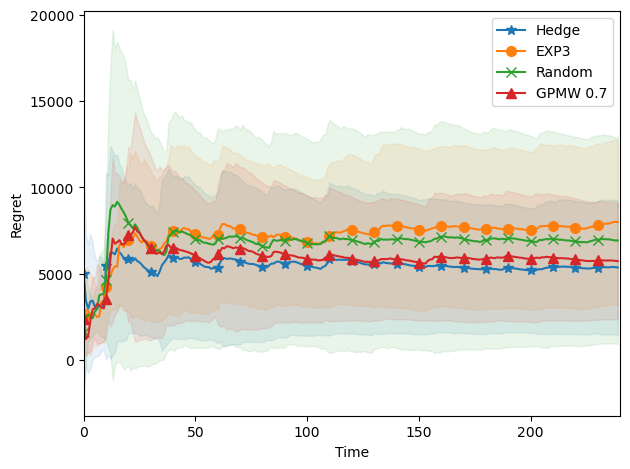

In [130]:
np.random.seed(12)
simulate(num_games=10, num_runs=1, T=10, N=3, K=5, file_name='res')
plot_regret('res')

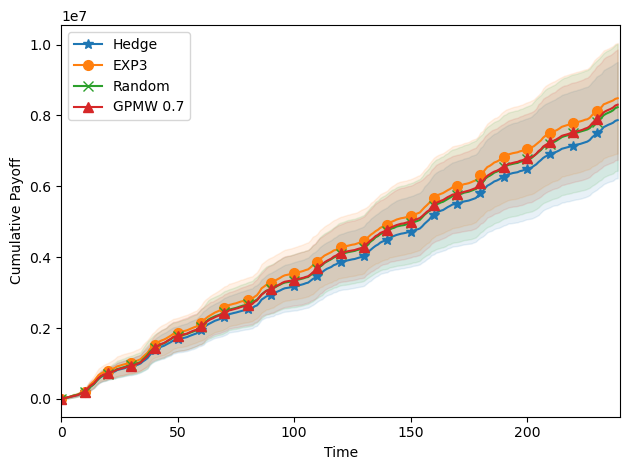

In [131]:
def plot_cumulative_payoff(file_name):
    markers = ['*', 'o', 'x', '^', '4', '3', ">", '2', 'd']
    with open(f'{file_name}.pckl', 'rb') as file:
        T = pickle.load(file)
        c_limit = pickle.load(file)
        d_limit = pickle.load(file)
        # Q = pickle.load(file)
        types = pickle.load(file)
        game_data_profile = pickle.load(file)

    T = T * 24

    idx_marker = 0
    for i, typ in enumerate(types):
        # Calculate cumulative payoffs for each player
        cumulative_payoffs = np.array([[np.sum(game_data_profile[i][d].payoffs[:t]) for t in range(T)] for d in range(len(game_data_profile[i]))])
        mean_payoff = np.mean(cumulative_payoffs, 0)
        std_payoff = np.std(cumulative_payoffs, 0)
        p = plt.plot(np.arange(T), mean_payoff, marker=markers[idx_marker], markevery=10, markersize=7, label=f'{typ}')
        color = p[0].get_color()
        plt.fill_between(range(T), mean_payoff - std_payoff, mean_payoff + std_payoff, alpha=0.1, color=color)

        idx_marker += 1

    plt.legend()
    plt.xlabel('Time (hours)')
    plt.xticks(np.arange(0, T + 1, 24), [f'{i}' for i in np.arange(0, T + 1, 24)])
    plt.xlim([0, T])
    plt.ylabel('Cumulative Payoff')
    plt.savefig('cumulative_payoff.png', bbox_inches="tight")
    plt.tight_layout()
    plt.show()    

# Call the functions with your file_name
file_name = 'res'
# plot_regret(file_name)
plot_cumulative_payoff(file_name)


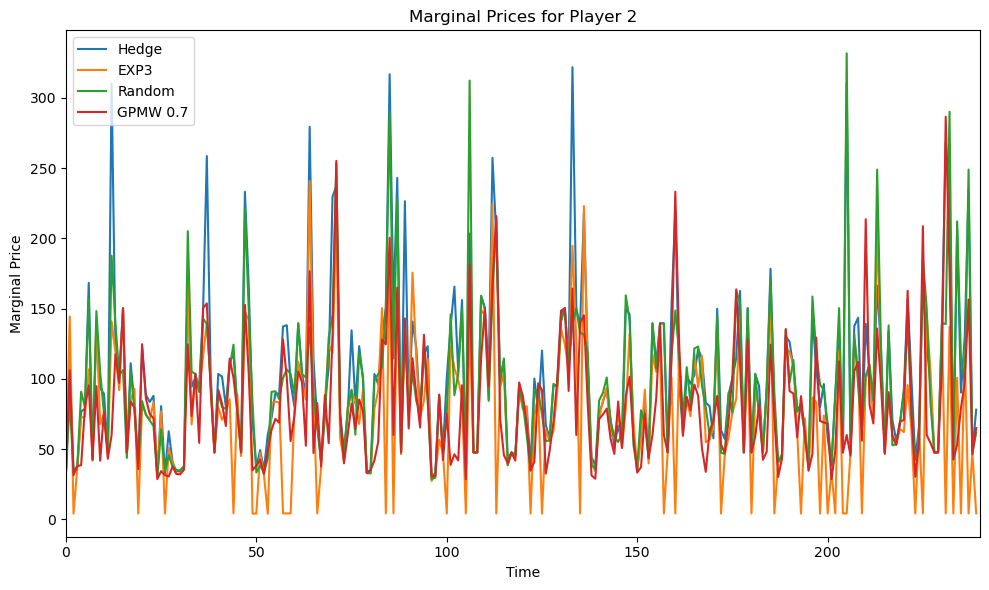

In [132]:
  
def plot_marginal_prices_for_player(file_name, player_idx):
    markers = ['*', 'o', 'x', '^', '4', '3', ">", '2', 'd']
    with open(f'{file_name}.pckl', 'rb') as file:
        T = pickle.load(file)
        c_limit = pickle.load(file)
        d_limit = pickle.load(file)
        types = pickle.load(file)
        game_data_profile = pickle.load(file)

    T = T * 24

    player_idx -= 1  # Adjusting player index to 0-based index

    plt.figure(figsize=(10, 6))

    for i, typ in enumerate(types):
        marginal_prices = np.array([game_data_profile[i][player_idx].marginal_prices[t] for t in range(T)])
        plt.plot(np.arange(T), marginal_prices, label=f'{typ}')

    plt.legend()
    plt.xlabel('Time (hour)')
    plt.xlim([0, T])
    plt.ylabel('Marginal Price')
    plt.xticks(np.arange(0, T + 1, 24), [f'{i}' for i in np.arange(0, T + 1, 24)])
    plt.title(f'Marginal Prices for Player {player_idx+1}')
    plt.savefig(f'marginal_prices_player_{player_idx+1}.png', bbox_inches="tight")
    plt.tight_layout()
    plt.show()

# Call the function with your file_name and player index
file_name = 'res'
player_index = 2  # Change this to the player index you want to plot
plot_marginal_prices_for_player(file_name, player_index)

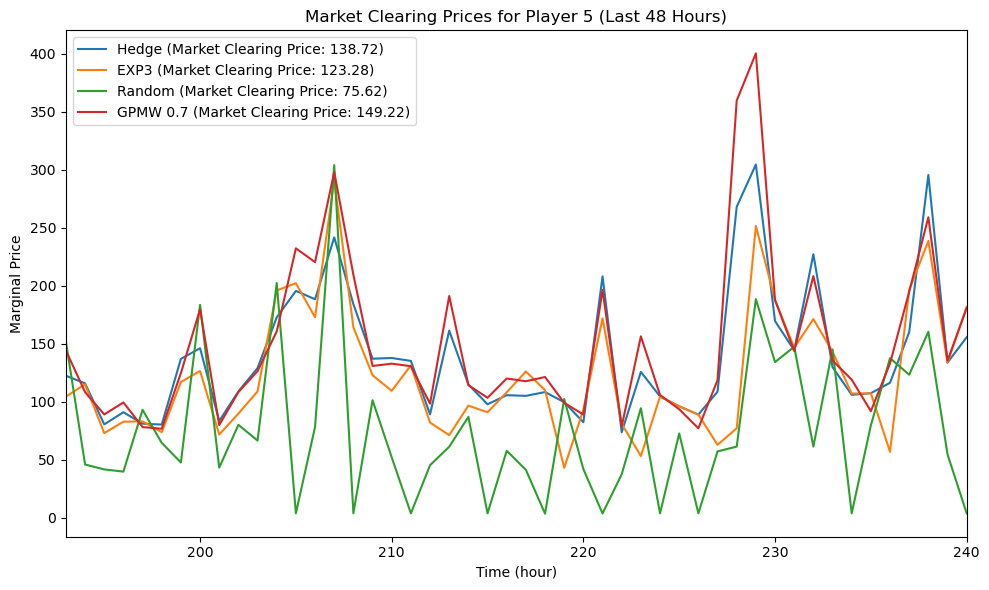

In [190]:
import matplotlib.pyplot as plt
import numpy as np

def plot_market_clearing_price(file_name, player_index):
    markers = ['*', 'o', 'x', '^', '4', '3', ">", '2', 'd']
    with open(f'{file_name}.pckl', 'rb') as file:
        T = pickle.load(file)
        c_limit = pickle.load(file)
        d_limit = pickle.load(file)
        types = pickle.load(file)
        game_data_profile = pickle.load(file)

    T = T * 24

    num_players = len(game_data_profile[3])

    if player_index >= num_players:
        print(f"Invalid player index. Please choose a player index between 0 and {num_players-1}.")
        return

    plt.figure(figsize=(10, 6))

    for i, typ in enumerate(types):
        marginal_prices = np.array([game_data_profile[i][player_index].marginal_prices[t] for t in range(T) if t >= (T - 48)])
        market_clearing_price = np.mean(marginal_prices)
        plt.plot(np.arange(T - 47, T + 1), marginal_prices, label=f'{typ} (Market Clearing Price: {market_clearing_price:.2f})')

    plt.legend()
    plt.xlabel('Time (hour)')
    plt.xlim([T - 47, T])
    plt.ylabel('Marginal Price')
    plt.title(f'Market Clearing Prices for Player {player_index + 1} (Last 48 Hours)')
    plt.tight_layout()
    plt.show()

# Call the function with your file_name and player index
file_name = 'res'
player_index = 4  # Change this to the player index you want to plot (0 to N-1)
plot_market_clearing_price(file_name, player_index)


In [ ]:
func_test(20, 5)

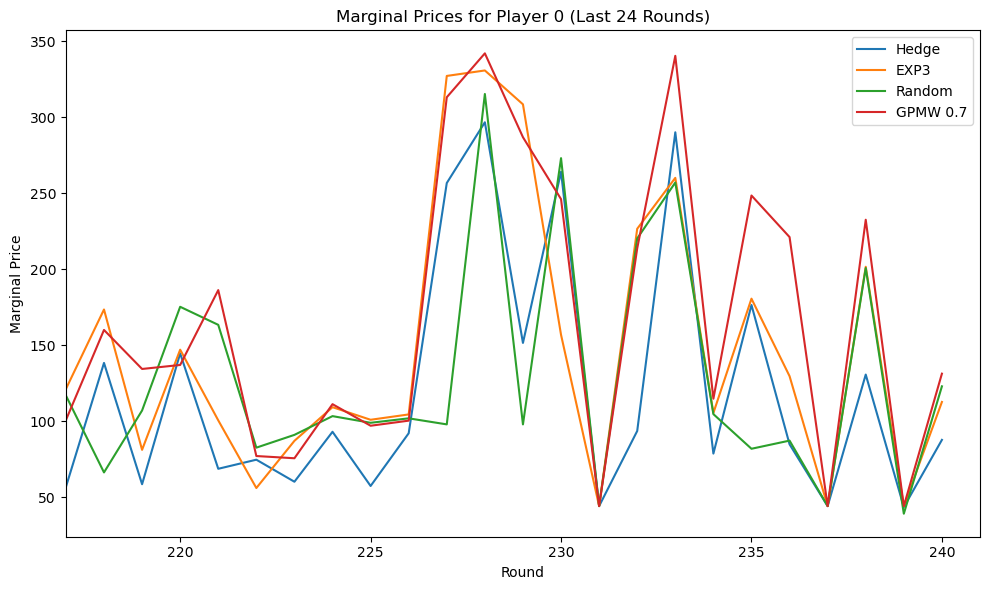

In [143]:
def plot_marginal_prices_for_player(file_name, player_idx):
    markers = ['*', 'o', 'x', '^', '4', '3', ">", '2', 'd']
    with open(f'{file_name}.pckl', 'rb') as file:
        T = pickle.load(file)
        c_limit = pickle.load(file)
        d_limit = pickle.load(file)
        types = pickle.load(file)
        game_data_profile = pickle.load(file)

    T_last_24 = T * 24 - 24  # Adjust T to the last 24

    player_idx -= 1  # Adjusting player index to 0-based index

    plt.figure(figsize=(10, 6))

    for i, typ in enumerate(types):
        marginal_prices = np.array([game_data_profile[i][player_idx].marginal_prices[t] for t in range(T_last_24, T * 24)])
        plt.plot(np.arange(T_last_24 + 1, T * 24 + 1), marginal_prices, label=f'{typ}')

    plt.legend()
    plt.xlabel('Round')
    plt.ylabel('Marginal Price')
    plt.xlim([T_last_24 + 1, T * 24 + 1])
    plt.title(f'Marginal Prices for Player {player_idx+1} (Last 24 Rounds)')
    plt.tight_layout()
    plt.show()

# Call the function with your file_name and player index
file_name = 'res'
player_index = 0  # Change this to the player index you want to plot
plot_marginal_prices_for_player(file_name, player_index)


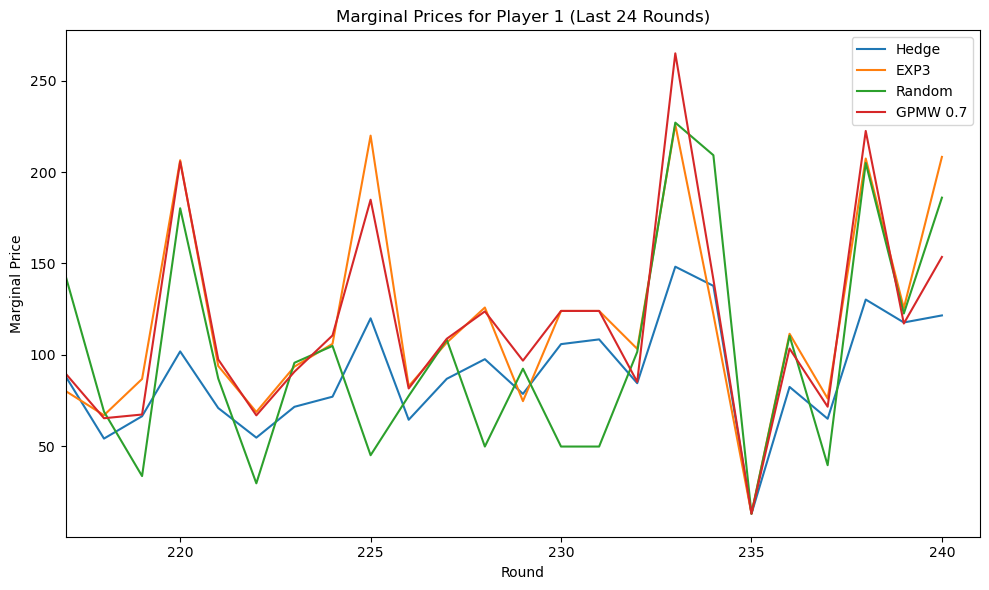

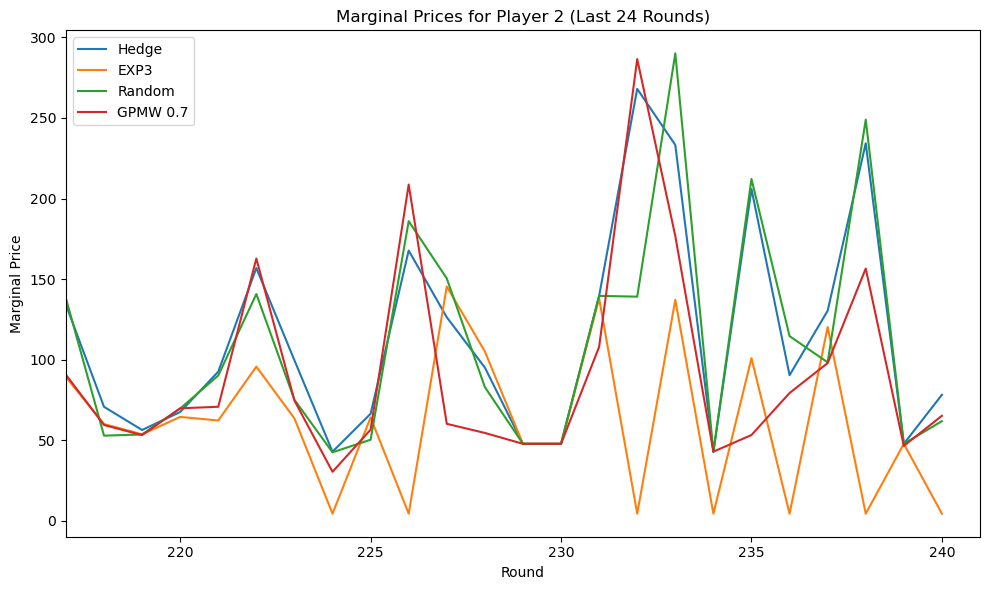

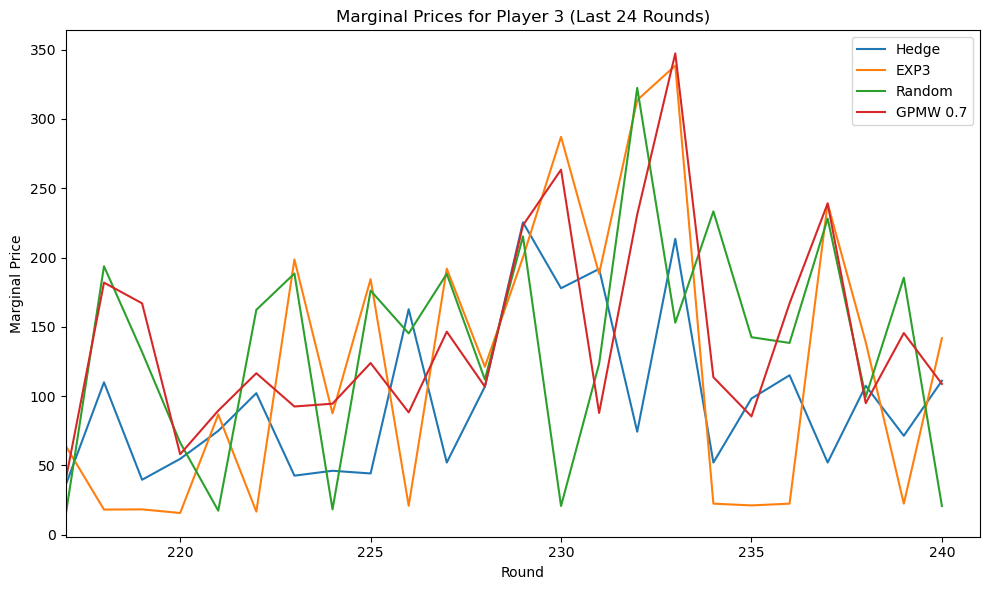

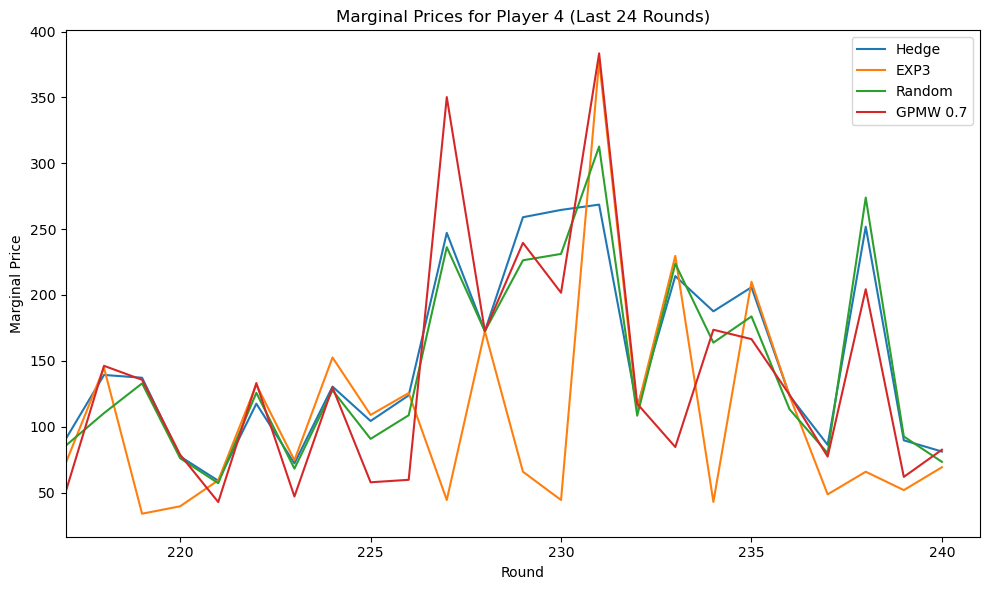

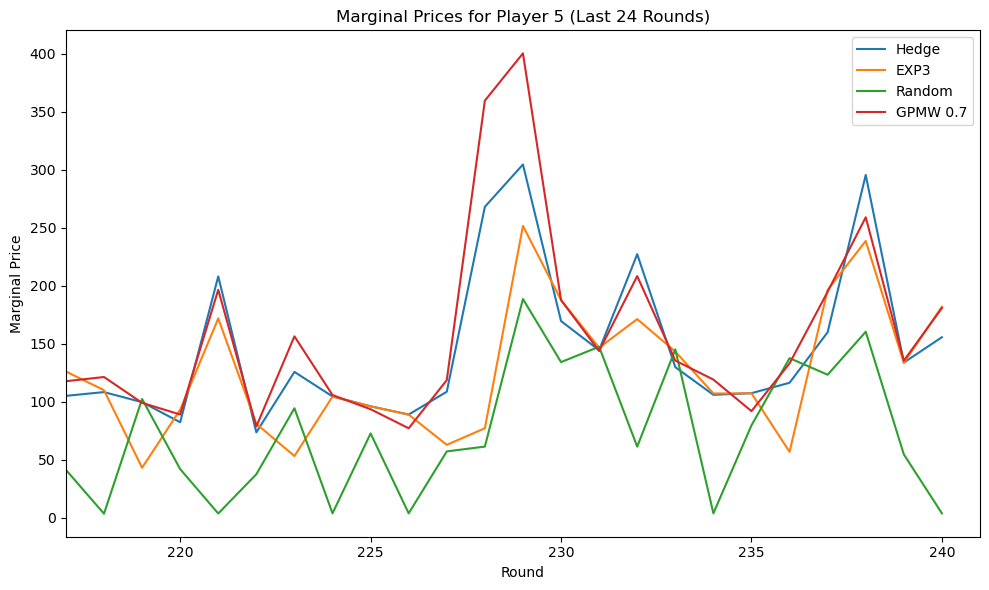

In [150]:
def plot_marginal_prices_for_player(file_name, player_idx):
    markers = ['*', 'o', 'x', '^', '4', '3', ">", '2', 'd']
    with open(f'{file_name}.pckl', 'rb') as file:
        T = pickle.load(file)
        c_limit = pickle.load(file)
        d_limit = pickle.load(file)
        types = pickle.load(file)
        game_data_profile = pickle.load(file)

    T_last_24 = T * 24 - 24  # Adjust T to the last 24

    num_players = len(game_data_profile[0])

    player_label = f'Player {player_idx + 1}'
    plt.figure(figsize=(10, 6))

    for i, typ in enumerate(types):
        marginal_prices = np.array([game_data_profile[i][player_idx].marginal_prices[t] for t in range(T_last_24, T * 24)])
        plt.plot(np.arange(T_last_24 + 1, T * 24 + 1), marginal_prices, label=f'{typ}')

    plt.legend()
    plt.xlabel('Round')
    plt.ylabel('Marginal Price')
    plt.xlim([T_last_24 + 1, T * 24 + 1])
    plt.title(f'Marginal Prices for {player_label} (Last 24 Rounds)')
    plt.tight_layout()
    plt.show()

# Call the function with your file_name and iterate player_index from 0 to N-1
file_name = 'res'
for player_index in range(N):
    plot_marginal_prices_for_player(file_name, player_index)
